Model: "ode"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                20        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


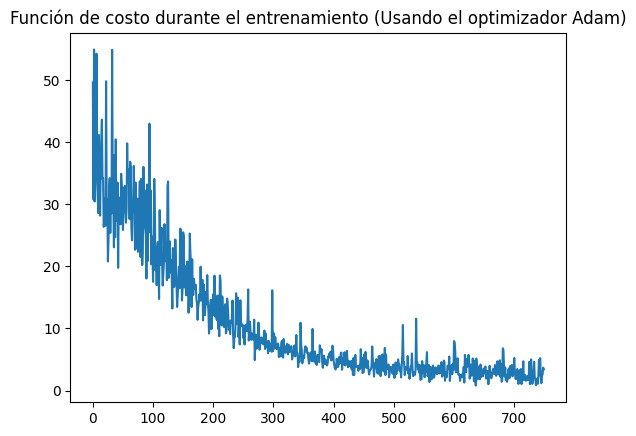

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam

import matplotlib.pyplot as plt
import numpy as np

"""
Creación del modelo para resolver una EDO a partir de un modelo de red ya 
creado. Se usará como herencia para este caso y no empezar a construir el 
modelo desde cero.
"""

class ODE(Sequential):
    # **kwargs significa "any extra keyword arguments"
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name = "loss")
        self.mse = tf.keras.losses.MeanSquaredError()
        
    @property 
    def metrics(self):
        return [self.loss_tracker]
    
    def train_step(self, data):
        batch = tf.shape(data)[0]
        min = tf.cast(tf.reduce_min(data),tf.float32)
        # Convierte los datos del tensor que contiene el  mínimo de
        # un tensor en datos de tipo flotante 32.
        max = tf.cast(tf.reduce_max(data), tf.float32)
        # Convierte los datos del tensor que contiene el máximo de
        # un tensor en datos de tipo flotante 32.
        x = tf.random.uniform((batch, 1), minval = min, maxval = max)
        
        with tf.GradientTape() as tape: 
            with tf.GradientTape() as tape2: 
                tape2.watch(x) # x es a la variable respecto a la cual se 
                                # realizará la derivación automática.
                y = self(x, training = True)
            dy = tape2.gradient(y,x)
            x_0 = tf.zeros(batch, 1)
            y_0 = tf.cast(self(x_0, training = True), tf.float32)
            
            eq = x*dy + y - (x**2)*tf.math.cos(x)
            initial_condition = 0.
            
            loss = self.mse(0., eq) + self.mse(y_0, initial_condition)
            
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
model = ODE()

model.add(Dense(10, activation = 'tanh', input_shape=(1,)))
model.add(Dense(1, activation = 'tanh'))
model.add(Dense(1))

model.summary()  

model.compile(optimizer = Adam(), metrics = ['loss'])

x=tf.linspace(-5,5,100)
history = model.fit(x,epochs = 750, verbose = 0)
plt.plot(history.history["loss"])
plt.title("Función de costo durante el entrenamiento (Usando el optimizador Adam)")
plt.show()

4/4 [==============================] - 0s 868us/step


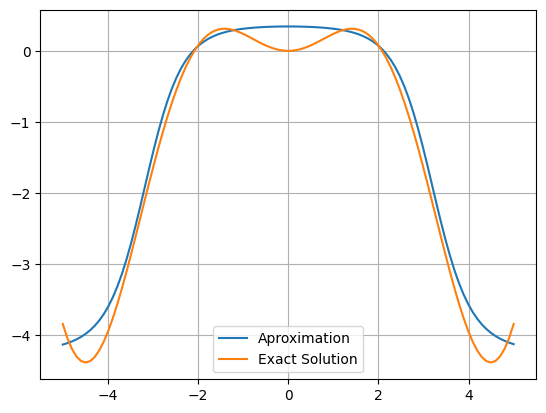

In [2]:
x_test = tf.linspace(-5, 5, 100)
y = model.predict(x_test)

plt.plot(x_test, y, label = "Aproximation")
plt.plot(x_test, (((x_test**2 - 2) * np.sin(x_test))/x + 2*np.cos(x_test)), label = "Exact Solution")
plt.grid()
plt.legend()
plt.show()

Model: "ode_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                20        
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


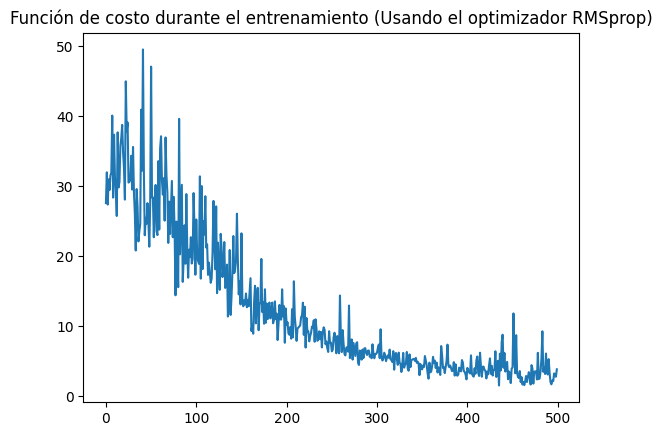

4/4 [==============================] - 0s 874us/step


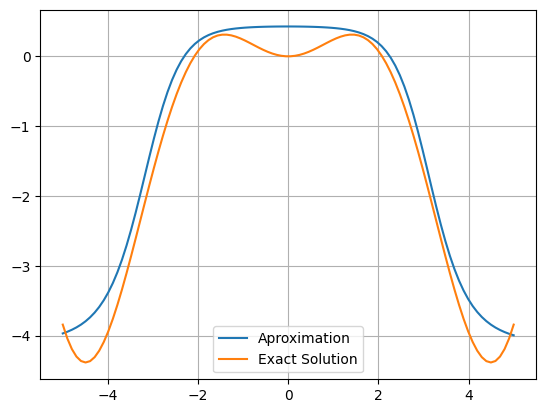

In [3]:
model2 = ODE()

model2.add(Dense(10, activation = 'tanh', input_shape=(1,)))
model2.add(Dense(1, activation = 'tanh'))
model2.add(Dense(1))

model2.summary()  
model2.compile(optimizer = RMSprop(), metrics = ['loss'])

history2 = model2.fit(x,epochs = 500, verbose = 0)

plt.plot(history2.history["loss"])
plt.title("Función de costo durante el entrenamiento (Usando el optimizador RMSprop)")
plt.show()

y = model2.predict(x_test)

plt.plot(x_test, y, label = "Aproximation")
plt.plot(x_test, (((x_test**2 - 2) * np.sin(x_test))/x + 2*np.cos(x_test)), label = "Exact Solution")
plt.grid()
plt.legend()
plt.show()